In [1]:
import torch # Tensor library
from torch import nn, optim # For create linear NN and optimizer
import torch.nn.functional as F # Activate functions 
from torchvision import datasets, transforms # Pytorch datasets, and image processing function library
import matplotlib.pyplot as plt # Drawing library
%matplotlib inline # Drawing on the same figure

***Download Fashion-MNIST Dataset***

In [2]:
# Normalize dataset, the gray data is in -1 and 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Training dataset
trainset = datasets.FashionMNIST('Dataset/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Testing dataset
testset = datasets.FashionMNIST('Dataset/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

If shuffle in testloader is False, you will fail to test the dataset by the model you trained in random

***Label List***

In [3]:
labellist = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

***Display the dataset***

In [4]:
def img_disp(trainloader, index):
    # Two variables: dataset and index, as the batch_size is 64, the valid interval of index is [0, 63]
    image, label = next(iter(trainloader))
    # iter returns an iterator for the given object; next: retrieves next item for the iterator
    imagedemo = image[index]
    imagedemolabel = label[index]
    imagedemo = imagedemo.reshape(28, 28)
    # To display the image, we need reshape the dataset as 28*28 (you can check the original shape of imagedemo)
    plt.imshow(imagedemo)
    print('The label of this image is:',labellist[imagedemolabel])

The label of this image is: Shirt


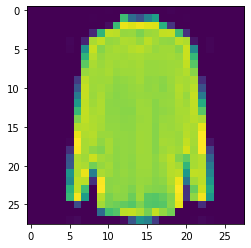

In [5]:
img_disp(trainloader, 0)

***GPU Environment***

In [6]:
!nvidia-smi

Mon Jul  4 01:40:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P5     7W /  N/A |      6MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Change the device as gpu, the name can be found by nvidia-smi
device = torch.device('cuda:0')

In [8]:
# Check the number of devices have been detected
torch.cuda.device_count()

1

***Neural Network***

In [9]:
# Simple linear neural network with dropout
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256) # 28*28=784
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10) # 10 refers to 10 classes in this task
        
        self.dropout = nn.Dropout(p=0.2) # Kill 20% neure in each layer (output layer not included)
    
    def forward(self, x):
        # The input tensor shoud be single column dataset, press channle, hight, width into one column
        x = x.view(x.shape[0], -1) # View is kinda of tensor.reshape
        x = self.dropout(F.relu(self.fc1(x))) # The activate function is ReLU()
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # The output layer no longer needs dropout
        x = F.log_softmax(self.fc4(x), dim=1) # To prevent data overflow
        x.to(device) # Save the results on gpu device
        
        return x

***Training***

In [10]:
def train_mnist(trainloader, testloader, criterion, optimizer, epochs):
    # Create three lists to save the data for further visualization
    train_losses, test_losses, acc = [], [], []
    print('Start Training')
    for e in range(epochs):
        running_loss = 0
        
        # Iterating all the training dataset
        for images, labels in trainloader:
            # Save the images and labels on GPU
            images = images.to(device)
            labels = labels.type(torch.LongTensor) # converting the type of label to torch.LongTensor before storing the data into the GPU
            labels = labels.to(device)
            # Set optimizer grad as 0, otherwise is will be accumulated
            optimizer.zero_grad()

            # Interfence the images, calculate loss function, backward optimize weights, add loss
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # For each training to learn, we perform a test
        else:
            test_loss = 0
            accuracy = 0
            # Durining test, we close the auto-grad and backward
            with torch.no_grad():
                # Close dropout
                model.eval()

                for images, labels in testloader:
                    # Save the images and labels on GPU
                    images = images.to(device)
                    labels = labels.type(torch.LongTensor)
                    labels = labels.to(device)
                    # Forward interfence, calculate loss, accuracy is calculates by testing 10,000 images
                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)
                    ps = torch.exp(log_ps) # As the return resutls is the log_softmax
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape) # equals here is to describe the highest possibility label predicted
                    # RHS is the accuracy for a batch=64
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
                    
            # Recover dropout
            model.train()
            # Save training and testing losses in two list for visualization
            train_losses.append(running_loss / len(trainloader))
            test_losses.append(test_loss.cpu().data.item() / len(testloader)) # Save the loss function results in CPU, give room to calculate other numbers
            accy = (accuracy.cpu().data.item() / len(testloader)) # Save the accuracy results in CPU, give room to calculate other numbers
            acc.append(accy)
            

            print('Training epoch {}/{}..'.format(e+1, epochs),
                  'Training loss: {:.3f}..'.format(running_loss/len(trainloader)),
                  'Test loss: {:.3f}..'.format(test_loss / len(testloader)),
                  'Accuracy: {:.3f}..'.format(accuracy / len(testloader)))
    return train_losses, test_losses, acc 

***Visualization***

In [11]:
def vis_loss(train_losses, test_losses, acc):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.plot(acc, label='Accuracy')
    plt.legend()

***Test***

In [12]:
def img_test(model, testloader):
    model.eval() # you need to turn off those specific layers (dropout, Batch Normalization) during model evaluation
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    #images = images.to(device)
    img = images[0]
    img = img.reshape(28,28).cpu()
    plt.imshow(img)
    
    # 1 dimensional test image
    img = img.view(1, 784)
    
    # Forward interfence, predict the class of image
    with torch.no_grad():
        img = img.to(device)
        output = model(img)
    ps = torch.exp(output)

    top_p, top_class = ps.topk(1, dim=1)
    prediction = labellist[top_class]
    probability = float(top_p)
    print(f'The model predict the image is {prediction}, pribability is {probability*100}%')

***Alchemy***

In [13]:
# Instance the 4 layer - Classifier
model = Classifier()
model.to(device) # Save the model on gpu device

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [14]:
# The loss function is Negative Log Loss function
criterion = nn.NLLLoss().to(device)

# Optimier
optimizer = optim.SGD(model.parameters(), lr = 0.003)

# Learning time
epochs = 25

In [15]:
train_losses, test_losses, acc = train_mnist(trainloader, testloader, criterion, optimizer, epochs)

Start Training
Training epoch 1/25.. Training loss: 2.148.. Test loss: 1.728.. Accuracy: 0.383..
Training epoch 2/25.. Training loss: 1.383.. Test loss: 1.012.. Accuracy: 0.652..
Training epoch 3/25.. Training loss: 1.007.. Test loss: 0.812.. Accuracy: 0.713..
Training epoch 4/25.. Training loss: 0.852.. Test loss: 0.711.. Accuracy: 0.736..
Training epoch 5/25.. Training loss: 0.768.. Test loss: 0.660.. Accuracy: 0.744..
Training epoch 6/25.. Training loss: 0.716.. Test loss: 0.630.. Accuracy: 0.754..
Training epoch 7/25.. Training loss: 0.682.. Test loss: 0.604.. Accuracy: 0.766..
Training epoch 8/25.. Training loss: 0.649.. Test loss: 0.580.. Accuracy: 0.780..
Training epoch 9/25.. Training loss: 0.626.. Test loss: 0.568.. Accuracy: 0.788..
Training epoch 10/25.. Training loss: 0.603.. Test loss: 0.545.. Accuracy: 0.796..
Training epoch 11/25.. Training loss: 0.581.. Test loss: 0.530.. Accuracy: 0.805..
Training epoch 12/25.. Training loss: 0.565.. Test loss: 0.513.. Accuracy: 0.811.

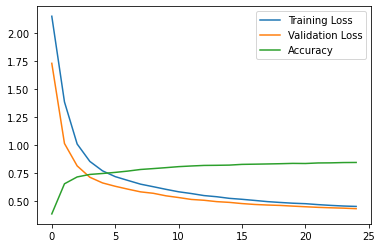

In [17]:
vis_loss(train_losses, test_losses, acc)

The model predict the image is Ankle Boot, pribability is 99.3361234664917%


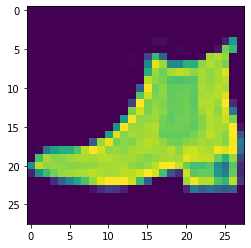

In [19]:
img_test(model, testloader)